# Modeling

We're going to try a few different tactics to see what gets us the best results.


1. Models based on the full feature set with PCA (for dimensionality reduction)
1. Models based on the full feature set without PCA.

1. Models based on a restricted set of features.


## Importing modules and data

In [118]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.decomposition import PCA


%matplotlib inline
sns.set_style('darkgrid')

In [119]:
np.random.seed(32)

In [120]:
df = pd.read_csv('../data/train_weather_spray_merged.csv')

In [121]:
df_dummied = pd.get_dummies(df, columns=['species'])

## Creating Validation Set, Scaling

In [122]:
df_dummied.drop(columns=['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'nummosquitos', 'sunrise', 'sunset'], axis=1, inplace=True)

In [123]:
features = [col for col in df_dummied if col != 'wnvpresent']

In [124]:
df_dummied.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'wnvpresent',
       'spray_nearby', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'tsra', 'sn', 'br', 'vcfg',
       'bcfg', 'hz', 'ra', 'dz', 'gr', 'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts',
       'fu', 'species_CULEX OTHER', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS'],
      dtype='object')

In [125]:
X = df_dummied[features]
y = df_dummied.wnvpresent

In [126]:
X.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'spray_nearby', 'station',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tsra', 'sn', 'br', 'vcfg', 'bcfg', 'hz', 'ra', 'dz', 'gr',
       'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts', 'fu', 'species_CULEX OTHER',
       'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS'],
      dtype='object')

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

In [128]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [129]:
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(ss, file)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [131]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [132]:
with open('../models/pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

## Logistic Regression w/out PCA 

Logistic regression attempts to estimate the odds that West Nile virus will be found 

In [69]:
logreg = LogisticRegression()
np.random.seed(41)
params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(1, 10, 5),
    'class_weight':['balanced']
}
gs_logreg = GridSearchCV(logreg, param_grid=params , scoring='roc_auc', verbose=1, return_train_score=True)

In [17]:
gs_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ]), 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [18]:
gs_logreg.best_params_

{'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2'}

In [19]:
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(0.7535689801385388, 0.7442577689841573)

In [20]:
session_results = {
    'l1':{'train':[],'test':[]},
    'l2':{'train':[],'test':[]},
}
m_test_s = gs_logreg.cv_results_['mean_test_score']
m_train_s = gs_logreg.cv_results_['mean_train_score']

for index, session in enumerate(gs_logreg.cv_results_['params']):
    penalty = session['penalty']
    session_results[penalty]['train'].append(m_train_s[index])
    session_results[penalty]['test'].append(m_test_s[index])

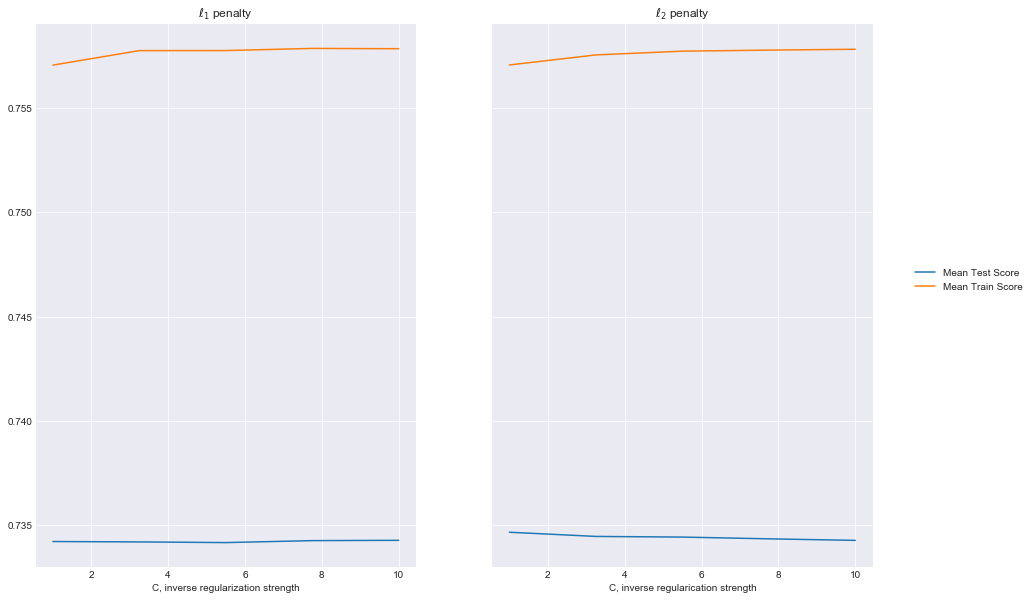

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)

mtest_l1, mtrain_l1 = session_results['l1']['test'], session_results['l1']['train']
ax[0].plot(params['C'], mtest_l1, label='Mean Test Score')
ax[0].plot(params['C'], mtrain_l1, label='Mean Train Score')
ax[0].set_title('$\ell_1$ penalty')
ax[0].set_xlabel('C, inverse regularization strength')

mtest_l2, mtrain_l2 = session_results['l2']['test'], session_results['l2']['train']
ax[1].plot(params['C'], mtest_l2, label='Mean Test Score')
ax[1].plot(params['C'], mtrain_l2, label='Mean Train Score')
ax[1].set_title('$\ell_2$ penalty')
ax[1].set_xlabel('C, inverse regularication strength')
ax[1].legend(loc=(1.1,.5))




In [22]:
feats = pd.Series(abs(gs_logreg.best_estimator_.coef_.T.reshape(-1)), index=X.columns)
feats[abs(feats).sort_values(ascending=False).index].head()

tmax                   1.590092
wetbulb                1.271839
species_CULEX OTHER    1.035669
tmin                   0.771596
tavg                   0.756529
dtype: float64

Looks like the unrestricted Logistic Regression model is overfitting with both regularizations since the training scores are much better than the validation scores. Very likely that this is an unreliable model. The coefficients on these scores indicate their relative contributions to the estimated probabilities with `tmax` being the dominant feature.

In [23]:
model_file = 'log_reg.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_logreg, file)

## Logistic Regression w/PCA on full set of features
For this Logistic Regression model, rather than using the class balancing setting we have manually resampled from those observations which observed West Nile virus to create balanced classes.

In [133]:
np.random.seed(41)
a = [i for i in range(len(y_train)) if y_train.iloc[i] == 1]
b = [i for i in range(len(y_train)) if y_train.iloc[i] == 0]

bootstrap = np.random.choice(a=a, size=7422, replace=True).tolist()
bootstrap.extend(b)

y_train_bs = y_train.iloc[bootstrap]
X_train_bs = X_train_pca[bootstrap,:]

In [147]:
lr = LogisticRegression()

params = {
    'penalty':['l1', 'l2'],
    'C':np.logspace(start=-5, stop=-1, num=1000),
    'class_weight':['balanced']
}
gs_lr_pca = GridSearchCV(lr, param_grid=params, return_train_score=True, scoring='roc_auc')
gs_lr_pca.fit(X_train_bs, y_train_bs)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.00926e-05, ..., 9.90823e-02, 1.00000e-01]), 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [148]:
session_results = {
    'l1':{'train':[],'test':[]},
    'l2':{'train':[],'test':[]},
}
m_test_s = gs_lr_pca.cv_results_['mean_test_score']
m_train_s = gs_lr_pca.cv_results_['mean_train_score']

for index, session in enumerate(gs_lr_pca.cv_results_['params']):
    penalty = session['penalty']
    session_results[penalty]['train'].append(m_train_s[index])
    session_results[penalty]['test'].append(m_test_s[index])

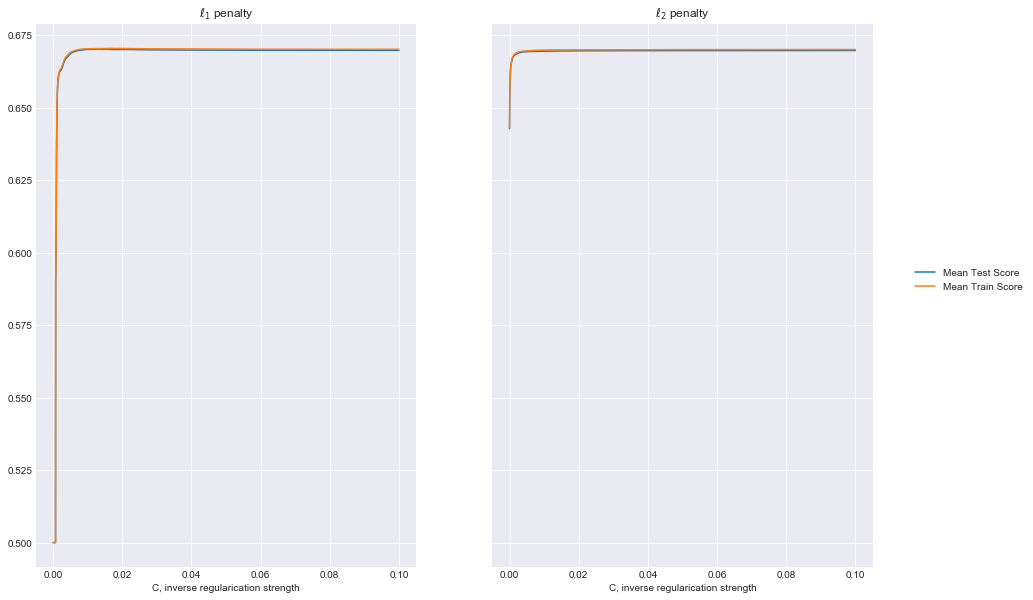

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)

mtest_l1, mtrain_l1 = session_results['l1']['test'], session_results['l1']['train']
ax[0].plot(params['C'], mtest_l1, label='Mean Test Score')
ax[0].plot(params['C'], mtrain_l1, label='Mean Train Score')
ax[0].set_title('$\ell_1$ penalty')
ax[0].set_xlabel('C, inverse regularication strength')

mtest_l2, mtrain_l2 = session_results['l2']['test'], session_results['l2']['train']
ax[1].plot(params['C'], mtest_l2, label='Mean Test Score')
ax[1].plot(params['C'], mtrain_l2, label='Mean Train Score')
ax[1].set_title('$\ell_2$ penalty')
ax[1].set_xlabel('C, inverse regularication strength')
ax[1].legend(loc=(1.1,.5))

In [150]:
gs_lr_pca.score(X_train_pca, y_train), gs_lr_pca.score(X_test_pca, y_test)

(0.6791872401075765, 0.6890337064637835)

In [151]:
gs_lr_pca.best_params_

{'C': 0.013650078065460139, 'class_weight': 'balanced', 'penalty': 'l1'}

In [152]:
feats = pd.Series(abs(gs_lr_pca.best_estimator_.coef_.T.reshape(-1)))
feats[abs(feats).sort_values(ascending=False).index]

5    0.348861
2    0.197167
3    0.151416
4    0.122714
0    0.075135
1    0.038367
6    0.000000
dtype: float64

The above feature coefficients indicate the relative importances of the features we synthesized using PCA. Each of these seven features is a linear combination of our original source features. The coefficients corresponding to the original features of the most important one for this model, feature 5, is shown below.

In [153]:
feats = pd.Series(data=pca.components_[0], index=X.columns)
feats[abs(feats).sort_values(ascending=False).index]

wetbulb                          -0.363634
dewpoint                         -0.354162
tavg                             -0.351860
tmin                             -0.348265
cool                             -0.338433
tmax                             -0.316734
heat                              0.255194
sealevel                          0.230610
stnpressure                       0.195946
tsra                             -0.160743
ts                               -0.140114
preciptotal                      -0.126794
br                               -0.121352
hz                               -0.097183
vcts                             -0.096332
avgspeed                         -0.071102
longitude                        -0.062147
resultdir                        -0.060382
latitude                          0.059770
station                          -0.057384
ra                               -0.053517
addressaccuracy                   0.050484
species_CULEX PIPIENS            -0.043324
fg         

In [154]:
model_file = 'log_reg_pca.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_lr_pca, file)

Similar results with $\ell_1$ and $\ell_2$ regularization, with a slight advantage to $\ell_1$. Not much evidence of overfitting in comparing the training and test scores.

## Decision Tree with full feature space.

The decision tree splits the data in sequence, at each step in the sequence maximizing the so called information gain. The features can, after fitting, be sorted by their cumulative contribution to the information gain of the model. This allows us to understand the relative importances placed on the different features by the model.   

In [37]:
params = {
    'min_samples_split' : range(2,10),
    'min_samples_leaf': range(2,10),
}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc',)

In [38]:
gs_dt.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(2, 10), 'min_samples_leaf': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
gs_dt.score(X_train, y_train), gs_dt.score(X_test, y_test)

(0.9444700374086579, 0.746124366108152)

In [40]:
pd.Series(gs_dt.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

longitude                0.257447
latitude                 0.210151
tmax                     0.067928
resultspeed              0.052287
tmin                     0.050179
preciptotal              0.042438
species_CULEX PIPIENS    0.038651
cool                     0.037607
resultdir                0.036322
avgspeed                 0.036041
dtype: float64

Our decision tree model is likely very overfit as evidenced by the discrepancy between the train and test scores. It also most heavily weights the location of a trap relative to the rest of the information, this can be seen by the fact that `longitude` and `latitude` are the highest ranked features by feature importances. 

In [42]:
model_file = 'dt.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_dt, file)

## Random Forest with full feature space

In [43]:
params = {
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2],
    'class_weight': ['balanced'],
}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc')

In [44]:
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [45]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.9741506107967304, 0.8023377109311443)

In [46]:
pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)

longitude          0.146669
latitude           0.138273
avgspeed           0.060383
tavg               0.057561
sealevel           0.053717
cool               0.051249
addressaccuracy    0.048267
wetbulb            0.045067
tmax               0.044106
resultspeed        0.041748
dtype: float64

Like the decision tree model before it, the Random Forest is likely overfit as evidenced by the discrepancy between the train and test scores. It seems __less__ overfit than the decision trees since this gap is smaller. Also like the decision tree, the Random Forest assigns the most predictive power to the position of the trap. 

In [49]:
gs_rf.best_params_

{'class_weight': 'balanced', 'min_samples_leaf': 2, 'min_samples_split': 4}

In [50]:
model_file = 'rf.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_rf, file)

## AdaBoost w/Logistic Regression base and PCA

In [61]:
np.random.seed(41)
ada = AdaBoostClassifier()
params = {
        'base_estimator':[LogisticRegression(class_weight='balanced')],
        'n_estimators': [500,1000, 1500],
}
gs_ada = GridSearchCV(ada, param_grid=params, scoring='roc_auc', verbose=1, return_train_score=True,)

%time gs_ada.fit(X_train_pca, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.8s finished


CPU times: user 1min 17s, sys: 1.44 s, total: 1min 18s
Wall time: 40.5 s


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator': [LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)], 'n_estimators': [500, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [62]:
gs_ada.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'n_estimators': 500}

In [63]:
gs_ada.score(X_train_pca, y_train), gs_ada.score(X_test_pca, y_test)

(0.678157247134909, 0.690105192739972)

This Adaboost model looks like it hasn't overfit since the test and training scores are very similar. This is an ensembled model on synthetic features, so interpreting how this model uses the individual features is doubly removed from the original feature space.

In [64]:
model_file = 'ada.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_ada, file)

## Bagging

In [66]:
np.random.seed(41)

bag = BaggingClassifier()
params = {
    'n_estimators': range(1,201, 25),
}
gs_bag = GridSearchCV(bag, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
%time gs_bag.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   35.4s finished


CPU times: user 38.1 s, sys: 292 ms, total: 38.4 s
Wall time: 38.7 s


GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 201, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

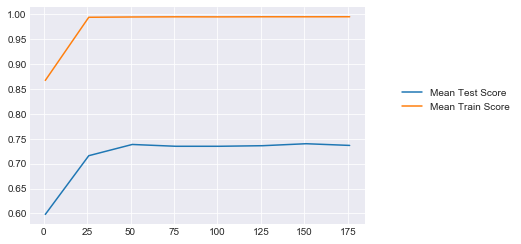

In [67]:
mtest, mtrain = gs_bag.cv_results_['mean_test_score'], gs_bag.cv_results_['mean_train_score']
plt.plot(params['n_estimators'], mtest, label='Mean Test Score')
plt.plot(params['n_estimators'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [68]:
gs_bag.best_params_

{'n_estimators': 151}

In [58]:
gs_bag.score(X_train, y_train), gs_bag.score(X_test, y_test)

(0.9925352753604809, 0.7819369523868916)

This Bagged model is very overfit with training scores close to 1 and much lower test scores. This is an ensemble model on synthetic features, so interpreting how this model uses the individual features is doubly removed from the original feature space.

In [59]:
model_file = 'bag.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_bag, file)

## KNN

In [86]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': range(2,20),  
    'weights':['uniform']
}
gs_knn = GridSearchCV(knn, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 20), 'weights': ['uniform']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

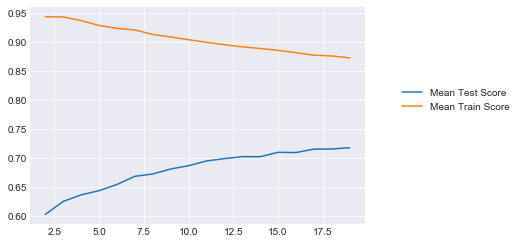

In [87]:
mtest, mtrain = gs_knn.cv_results_['mean_test_score'], gs_knn.cv_results_['mean_train_score']
plt.plot(params['n_neighbors'], mtest, label='Mean Test Score')
plt.plot(params['n_neighbors'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [88]:
gs_knn.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [89]:
gs_knn.score(X_train, y_train), gs_knn.score(X_test, y_test)

(0.8733116899414037, 0.7556812866906097)

In [90]:
model_file = 'knn.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_knn, file)

Some very bizarre behavior in the training and testing scores, test score is increasing for (approximately) k between 1 and 20, then decreasing while training scores is strictly decreasing. 

## Restricting the Feature Space

In [16]:
limited_cols = ['latitude', 'longitude', 'tmax', 'species', 'wnvpresent']
lim_features = [col for col in df[limited_cols] if col != 'wnvpresent']
X_limited = pd.get_dummies(df[lim_features])
X_limited.drop(columns=['species_CULEX OTHER','species_CULEX PIPIENS/RESTUANS','species_CULEX RESTUANS'], inplace=True)
y_limited = df[limited_cols]['wnvpresent']

In [92]:
X_trl, X_tsl, y_trl, y_tsl = train_test_split(X_limited, y_limited)

In [93]:
X_limited.columns

Index(['latitude', 'longitude', 'tmax', 'species_CULEX PIPIENS'], dtype='object')

In [94]:
ss_limited = StandardScaler()
X_trl = ss_limited.fit_transform(X_trl)
X_tsl = ss_limited.transform(X_tsl)


## Decision Tree

In [96]:
params = {
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'max_depth': range(5, 25),
    'class_weight' : ['balanced'],
    'max_features': ['auto', None],
    'random_state': [32],
}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='roc_auc')

In [97]:
gs_dt.fit(X_trl, y_trl)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2, 3, 4], 'max_depth': range(5, 25), 'class_weight': ['balanced'], 'max_features': ['auto', None], 'random_state': [32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [98]:
gs_dt.score(X_trl, y_trl), gs_dt.score(X_tsl, y_tsl)

(0.7264835333217092, 0.6975460696579464)

In [100]:
gs_dt.best_params_

{'class_weight': 'balanced',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'random_state': 32}

In [99]:
model_file = 'dt_lf.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_dt, file)

## Random Forests

In [102]:
params = {
    'min_samples_split': [3],
    'min_samples_leaf': range(5, 11, 1),
    'class_weight': ['balanced'],
    'n_estimators': [1000],
}

gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='roc_auc', verbose=1)

In [103]:
gs_rf.fit(X_trl, y_trl)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3], 'min_samples_leaf': range(5, 11), 'class_weight': ['balanced'], 'n_estimators': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [104]:
gs_rf.score(X_trl, y_trl), gs_rf.score(X_tsl, y_tsl)

(0.9238036362483555, 0.7258752597220371)

In [108]:
gs_rf.best_params_

{'class_weight': 'balanced',
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'n_estimators': 1000}

In [109]:
model_file = 'rf_lf.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_rf, file)